In [4]:
import os
import numpy as np
np.random.seed(0)
import pandas as pd
# print(pd.__version__)
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display='diagram')

In [5]:
DATA_PATH = os.path.abspath(
    r'C:\Selbststudium\Udemy\Udemy_Machine_Learning\Abschnitt_13\adult_XLS.xls')
    

In [6]:
df = pd.read_excel(DATA_PATH)

In [7]:
idx = np.where(df['native-country']=='Holand-Netherlands')[0]

In [8]:
data = df.to_numpy()
x = data[:, :-1] # Letzte Spalte sind die y-Werte
x = np.delete(x, idx, axis = 0)
y = data[:, -1]
y = np.delete(y, idx, axis = 0)

print(f'x-Shape: {x.shape}\ny-Shape: {y.shape}')

x-Shape: (48841, 10)
y-Shape: (48841,)


In [9]:
# y-Daten aufbereiten
def one_hot(y):
    return np.array([0 if val == "<=50K" else 1 for val in y], dtype=np.int32)

In [10]:
print(y)
y = one_hot(y)
print(y)

['<=50K' '<=50K' '>50K' ... '<=50K' '<=50K' '>50K']
[0 0 1 ... 0 0 1]


In [11]:
# GridSearch Helper
def print_grid_cv_results(grid_result):
    print(
        f'Best model score: {grid_result.best_score_}'
        f'Best model params: {grid_result.best_params_}'
    )
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, std, param in zip(means, stds, params):
        mean = round(mean, 4)
        std = round(std, 4)
        print(f'{mean} (+/- {2 * std}) with: {param}')

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [14]:
params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 100, 200]
}

clf = RandomForestClassifier()

# Ordinal Features

In [15]:
categorical_features = [1, 2, 3, 4, 5, 6, 7, 9]
numerical_features = [0, 8]

numeric_transformer = Pipeline(
    steps = [
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ('oridnal', OrdinalEncoder())
    ]
)

preprocessor_ordinal = ColumnTransformer(
    transformers = [
        ('numeric', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)

In [16]:
preprocessor_ordinal

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 [0, 8]),
                                ('categorical',
                                 Pipeline(steps=[('oridnal',
                                                  OrdinalEncoder())]),
                                 [1, 2, 3, 4, 5, 6, 7, 9])])

In [17]:
preprocessor_ordinal.fit(x_train)
x_train_ordinal = preprocessor_ordinal.transform(x_train)
x_test_ordinal = preprocessor_ordinal.transform(x_test)
print(f'x_train_ord: {x_train_ordinal.shape}\ny_train_ord: {x_test_ordinal.shape}')

x_train_ord: (34188, 10)
y_train_ord: (14653, 10)


In [18]:
pipe_ordinal = Pipeline(
    steps = [
        ('preprocessor_ordinal', preprocessor_ordinal),
        ('classifier', clf) # Dieses "Classifier" muss in den Params angegeben werden
    ]
)

In [19]:
pipe_ordinal

Pipeline(steps=[('preprocessor_ordinal',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 8]),
                                                 ('categorical',
                                                  Pipeline(steps=[('oridnal',
                                                                   OrdinalEncoder())]),
                                                  [1, 2, 3, 4, 5, 6, 7, 9])])),
                ('classifier', RandomForestClassifier())])

In [20]:
grid_ordinal = GridSearchCV(pipe_ordinal, params, cv=3)
grid_results_oridnal = grid_ordinal.fit(x_train, y_train)
print_grid_cv_results(grid_results_oridnal)

Best model score: 0.817947817947818Best model params: {'classifier__max_depth': 200, 'classifier__n_estimators': 200}
0.8169 (+/- 0.0022) with: {'classifier__max_depth': None, 'classifier__n_estimators': 50}
0.8173 (+/- 0.002) with: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
0.8178 (+/- 0.0016) with: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
0.8174 (+/- 0.0024) with: {'classifier__max_depth': 100, 'classifier__n_estimators': 50}
0.8179 (+/- 0.002) with: {'classifier__max_depth': 100, 'classifier__n_estimators': 100}
0.8179 (+/- 0.0036) with: {'classifier__max_depth': 100, 'classifier__n_estimators': 200}
0.8169 (+/- 0.001) with: {'classifier__max_depth': 200, 'classifier__n_estimators': 50}
0.8174 (+/- 0.0034) with: {'classifier__max_depth': 200, 'classifier__n_estimators': 100}
0.8179 (+/- 0.0012) with: {'classifier__max_depth': 200, 'classifier__n_estimators': 200}


# OneHot Features

In [21]:
categorical_features = [1, 2, 3, 4, 5, 6, 7, 9]
numerical_features = [0, 8]

numeric_transformer = Pipeline(
    steps = [
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)

preprocessor_onehot = ColumnTransformer(
    transformers = [ 
        ('numeric', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)

In [22]:
preprocessor_onehot

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 [0, 8]),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [1, 2, 3, 4, 5, 6, 7, 9])])

In [23]:
preprocessor_onehot.fit(x_train)
x_train_onehot = preprocessor_onehot.transform(x_train)
x_test_onehot = preprocessor_onehot.transform(x_test)

print(f'x_train_onehot: {x_train_onehot.shape}\nx_test_onehot: {x_test_onehot.shape}')


x_train_onehot: (34188, 103)
x_test_onehot: (14653, 103)


In [24]:
pipe_onehot = Pipeline(
    steps = [
        ('preprocessor_onehot', preprocessor_ordinal),
        ('classifier', clf) # Dieses "Classifier" muss in den Params angegeben werden
    ]
)

In [25]:
pipe_onehot

Pipeline(steps=[('preprocessor_onehot',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 8]),
                                                 ('categorical',
                                                  Pipeline(steps=[('oridnal',
                                                                   OrdinalEncoder())]),
                                                  [1, 2, 3, 4, 5, 6, 7, 9])])),
                ('classifier', RandomForestClassifier())])

In [26]:
grid_ordinal = GridSearchCV(pipe_onehot, params, cv=3)
grid_results_onehot = grid_ordinal.fit(x_train, y_train)
print_grid_cv_results(grid_results_onehot)

Best model score: 0.818094068094068Best model params: {'classifier__max_depth': 100, 'classifier__n_estimators': 200}
0.8173 (+/- 0.0016) with: {'classifier__max_depth': None, 'classifier__n_estimators': 50}
0.8167 (+/- 0.0016) with: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
0.8173 (+/- 0.0038) with: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
0.818 (+/- 0.0024) with: {'classifier__max_depth': 100, 'classifier__n_estimators': 50}
0.8177 (+/- 0.005) with: {'classifier__max_depth': 100, 'classifier__n_estimators': 100}
0.8181 (+/- 0.0016) with: {'classifier__max_depth': 100, 'classifier__n_estimators': 200}
0.8163 (+/- 0.002) with: {'classifier__max_depth': 200, 'classifier__n_estimators': 50}
0.8179 (+/- 0.003) with: {'classifier__max_depth': 200, 'classifier__n_estimators': 100}
0.8175 (+/- 0.002) with: {'classifier__max_depth': 200, 'classifier__n_estimators': 200}


# TensorFlow Model

In [27]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [28]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [29]:
def build_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(units=128, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dense(units=64))
    model.add(Activation('relu'))
    model.add(Dense(units=output_dim))
    model.add(Activation('sigmoid'))
    return model

## NN with ordinal features

In [30]:
model = build_model(
    input_dim=x_train_ordinal.shape[1],
    output_dim=y_train.shape[1]
)

model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['binary_accuracy']
)

history_ordinal = model.fit(
    x=x_train_ordinal,
    y=y_train,
    epochs=20,
    validation_data=(x_test_ordinal, y_test)
)

Epoch 1/20
1069/1069 [==============================] - 1s 918us/step - loss: 0.5099 - binary_accuracy: 0.7580 - val_loss: 0.4911 - val_binary_accuracy: 0.7600
Epoch 2/20
1069/1069 [==============================] - 1s 675us/step - loss: 0.4825 - binary_accuracy: 0.7590 - val_loss: 0.4745 - val_binary_accuracy: 0.7594
Epoch 3/20
1069/1069 [==============================] - 1s 712us/step - loss: 0.4744 - binary_accuracy: 0.7636 - val_loss: 0.5350 - val_binary_accuracy: 0.7601
Epoch 4/20
1069/1069 [==============================] - 1s 654us/step - loss: 0.4702 - binary_accuracy: 0.7650 - val_loss: 0.4640 - val_binary_accuracy: 0.7681
Epoch 5/20
1069/1069 [==============================] - 1s 659us/step - loss: 0.4670 - binary_accuracy: 0.7657 - val_loss: 0.4621 - val_binary_accuracy: 0.7709
Epoch 6/20
1069/1069 [==============================] - 1s 714us/step - loss: 0.4638 - binary_accuracy: 0.7683 - val_loss: 0.4766 - val_binary_accuracy: 0.7695
Epoch 7/20
1069/1069 [==================

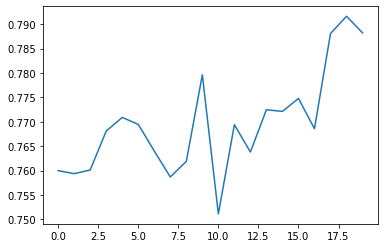

In [31]:
val_binary_accuracy = history_ordinal.history['val_binary_accuracy']
plt.plot(range(len(val_binary_accuracy)), val_binary_accuracy)
plt.show()

## NN with onehot features

In [32]:
model = build_model(
    input_dim=x_train_onehot.shape[1],
    output_dim=y_train.shape[1]
)

model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['binary_accuracy']
)

history_onehot = model.fit(
    x=x_train_onehot,
    y=y_train,
    epochs=20,
    validation_data=(x_test_onehot, y_test)
)

Epoch 1/20
1069/1069 [==============================] - 1s 853us/step - loss: 0.6015 - binary_accuracy: 0.7045 - val_loss: 0.5293 - val_binary_accuracy: 0.7603
Epoch 2/20
1069/1069 [==============================] - 1s 708us/step - loss: 0.5025 - binary_accuracy: 0.7609 - val_loss: 0.4809 - val_binary_accuracy: 0.7603
Epoch 3/20
1069/1069 [==============================] - 1s 706us/step - loss: 0.4641 - binary_accuracy: 0.7633 - val_loss: 0.4490 - val_binary_accuracy: 0.7674
Epoch 4/20
1069/1069 [==============================] - 1s 715us/step - loss: 0.4373 - binary_accuracy: 0.7773 - val_loss: 0.4266 - val_binary_accuracy: 0.7837
Epoch 5/20
1069/1069 [==============================] - 1s 818us/step - loss: 0.4190 - binary_accuracy: 0.7947 - val_loss: 0.4114 - val_binary_accuracy: 0.7998
Epoch 6/20
1069/1069 [==============================] - 1s 744us/step - loss: 0.4067 - binary_accuracy: 0.8053 - val_loss: 0.4011 - val_binary_accuracy: 0.8100
Epoch 7/20
1069/1069 [==================

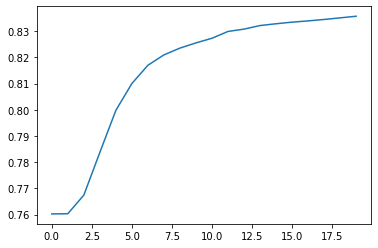

In [33]:
val_binary_accuracy = history_onehot.history['val_binary_accuracy']
plt.plot(range(len(val_binary_accuracy)), val_binary_accuracy)
plt.show()

## Pass in user-data

In [34]:
pipe_ordinal.fit(x_train, y_train)
score = pipe_ordinal.score(x_test, y_test)

print(f'score: {score}')

C:\Users\gutsc\anaconda3\envs\tensor_gpu\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


score: 0.8188084351327374


In [35]:
x_sample = [
    25,
    'Private',
    '11th',
    'Never-married',
    'Machine-op-inspct',
    'Own-child',
    'Black',
    'Male',
    40,
    'United-States'
]
y_sample = 0

y_pred_sample = pipe_ordinal.predict([x_sample])
print(f'y_sample: {y_sample}\ny_pred: {y_pred_sample}')

y_sample: 0
y_pred: [0]
